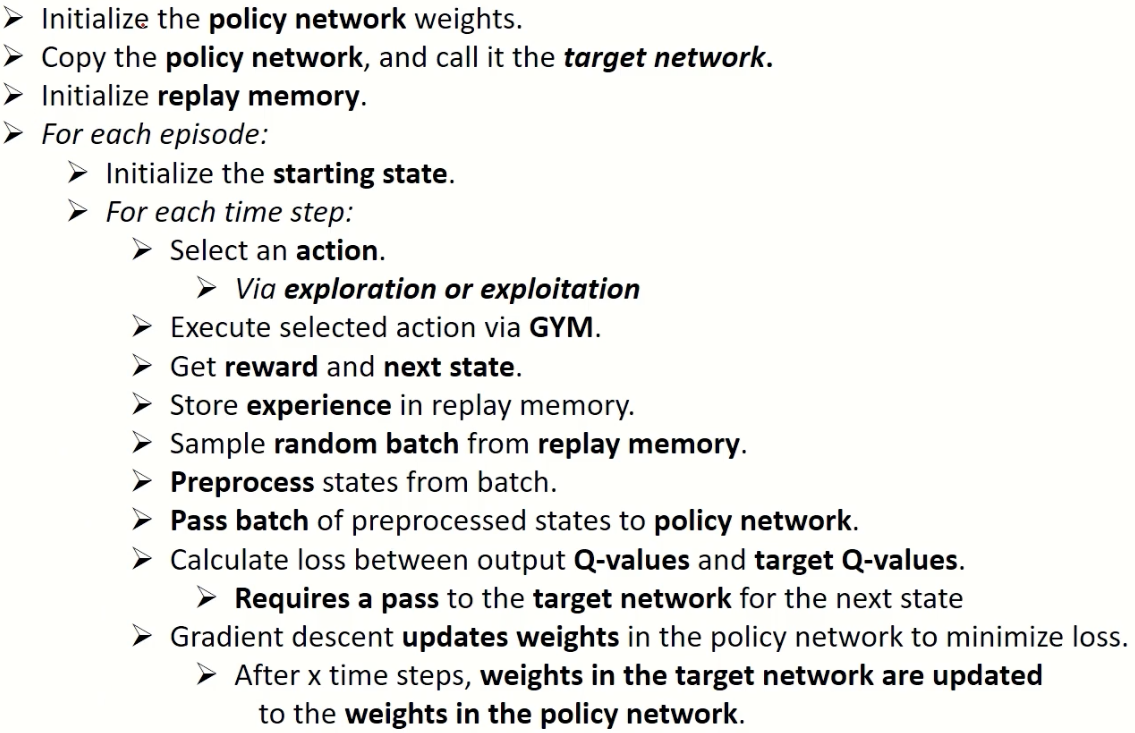

In [ ]:
from IPython.display import Image
Image(filename='bbb.png')

### Policy Network is just a neural network. Q-values are coming from Policy Network while target Q-values are coming from Target Network

#### Cartpole-v0 is considered "solved" when the agent obtains an average reward of at least 195.0 over 100 consecutive episodes. In gym, if the cart can hold the pole for 1 time step then it gets a reward of 1 else 0.

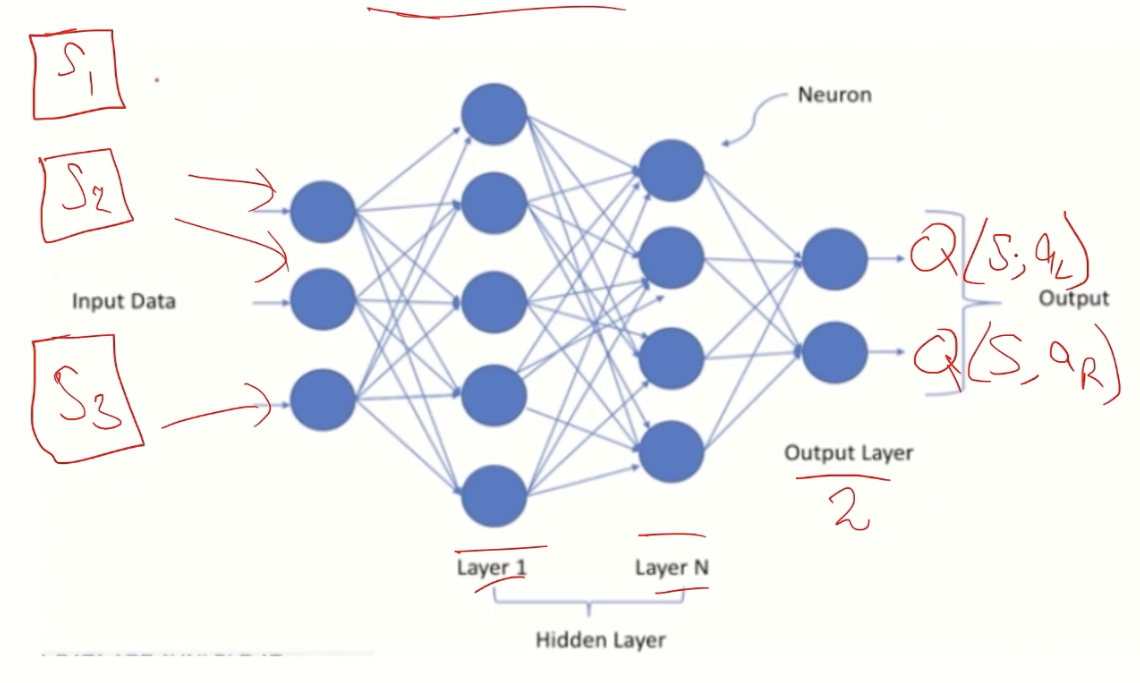

In [ ]:
# Policy Network Forward Propagation
Image(filename='ccc.png')

### Since, by looking at just one state of the cartpole, we cannot say where the cartpole system is moving, therefore we provide states in sequence via the input layer. The output layer has 2 neurons since two actions can be taken (+1 and -1) i.e. to right or left.

## Importing necessary libraries

In [29]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

is_python = 'inline' in matplotlib.get_backend()
if is_python: from IPython import display

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Defining the DQN Class

In [30]:
class DQN(nn.Module):

    def __init__(self, img_height, img_width):
        super().__init__()

        # multiplied by 3 because we are dealing with RGB for image
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

        # t refers to tensor
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

# This same class will work for target as well

### Replay Memory is just a list of experiences and experience is a Tuple of State(s), Action(a), Reward(R) and Next State(s').

In [ ]:
# Now, RM = [e1,e2,e3,e4,...]
# and capacity how many experiences can you store in your memory. This is a hyperparameter

In [31]:
#named tuple is an ordinary tuple but we can use it as a dictionary

Experience = namedtuple(
'Experience',('state', 'action', 'next_state', 'reward')

)

# example, how it stores the values
e = Experience(1,2,3,4)
e

Experience(state=1, action=2, next_state=3, reward=4)

## Defining the Replay Memory Class

In [32]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # list of experiences
        self.count = 0


    def push(self, exp):
        if len(self.memory) < self.capacity:
            self.memory.append(exp)

        else:
            self.memory[self.count%self.capacity] = exp
        self.count+=1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


    # Why do we want to process a random batch?
    # Hint: Correlation- to break the correlation and provide randomness

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [33]:
class EpsilonGreedyStrategy():

    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, step):
        return self.end + (self.start -  self.end)* math.exp(-1.*step*self.decay)

In [34]:
class Agent():
    def __init__(self, strategy, num_actions, device):

        self.step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):

        rate = self.strategy.get_exploration_rate(self.step)

        self.step+=1

        if rate > random.random(): # exploration
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) #returning action in the form of tensor

        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploiting

In [74]:
class EnvManager():

    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()

        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()[0]

        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode ='human'):
        return self.env.render(mode)


    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):

        _, reward, self.done, __, ___ = self.env.step(action.item()) # to get mathematical value of action from tensor .item
        return torch.tensor([reward], device = self.device)

    def just_starting(self):
        return self.current_screen is None


    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen=screen[:, top:bottom,:]
        return screen

    def transform_screen(self,screen):
        screen = np.ascontiguousarray(screen, dtype = np.float32)/255
        screen = torch.from_numpy(screen)

        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()

        ])

        return resize(screen).unsqueeze(0).to(self.device)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for

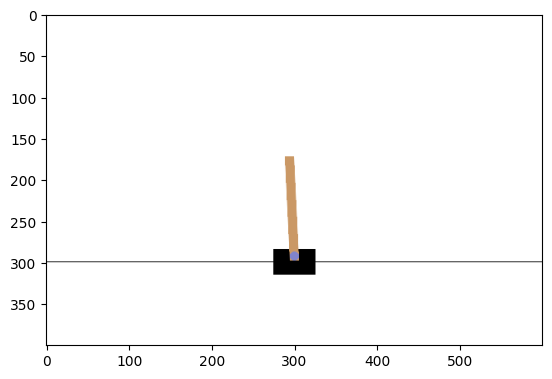

In [36]:
# Non processed screen

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = EnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.show()

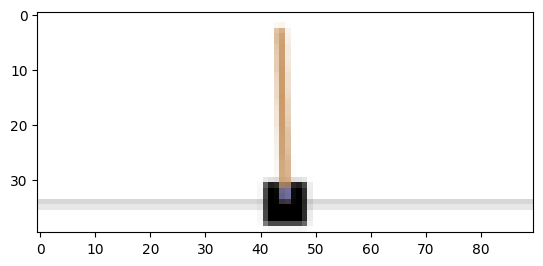

In [37]:
# Processed Screen

screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation = None)
plt.show()

In [89]:
def get_moving_avg(values, period):

  values = torch.tensor(values, dtype=torch.float)

  if len(values) >= period:
    moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period-1), moving_avg))

  else:
    moving_avg = torch.zeros(len(values))

  return moving_avg.numpy()

In [39]:
get_moving_avg(np.random.rand(300), 100)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [40]:
from IPython import get_ipython

In [41]:
def plot(values, moving_avg_period):
  plt.figure(2)
  plt.clf()
  plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(values)

  moving_avg = get_moving_avg(values, moving_avg_period)
  plt.plot(moving_avg)
  plt.pause(0.001)
  print("Episode", len(values), "\n", \
            moving_avg_period, " last episode moving avg:", moving_avg[-1])
  is_ipython = get_ipython() is not None
  if is_ipython:
      from IPython import display #Import display if in IPython environment
      display.clear_output(wait=True)

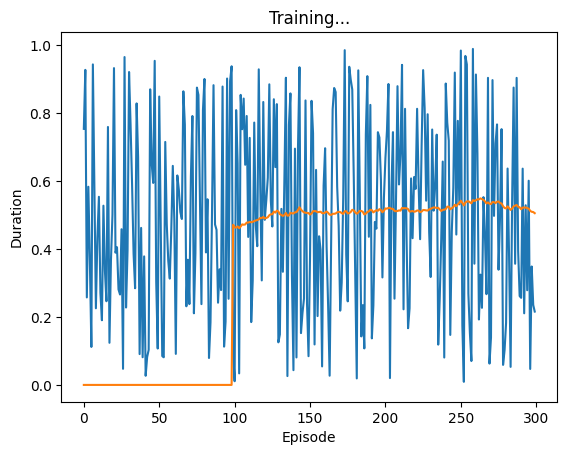

Episode 300 
 100  last episode moving avg: 0.5057158


In [42]:
plot(np.random.rand(300), 100)

We need to stop when the moving average reaches 195 because that is the criteria

In [75]:
batch_size = 256

gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001

target_update = 10

memory_size = 100000
lr = 0.001

num_episodes = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
em = EnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [77]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [78]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [79]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [80]:
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)

In [83]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

exps = [e1,e2,e3]
exps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [84]:
batch = Experience(*zip(*exps))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

In [85]:
def extract_tensors(experiences):
  batch = Experience(*zip(*experiences))

  t1 = torch.cat(batch.state)
  t2 = torch.cat(batch.action)
  t3 = torch.cat(batch.reward)
  t4 = torch.cat(batch.next_state)

  return (t1,t2,t3,t4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
class QValues():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  @staticmethod
  def get_current(policy_net, states, actions):
    return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

  @staticmethod
  def get_next(target_net, next_states):
    final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
    non_final_state_locations = (final_state_locations == False)

    non_final_states = next_states[non_final_state_locations]
    batch_size = next_states.shape[0]
    values = torch.zeros(batch_size).to(QValues.device)
    values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
    return values

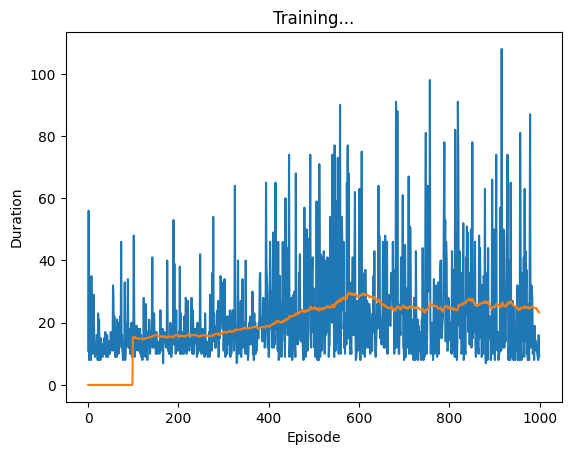

Episode 1000 
 100  last episode moving avg: 23.31


In [90]:
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()


    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()

        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)


            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
      target_net.load_state_dict(policy_net.state_dict())
em.close()